In [15]:
import pandas as pd
import numpy as np
from pycaret.regression import *

# W_LEV_AVG	= ค่าระดับน้ำทะเล หน่วยเมตร
# Load your dataset
df = pd.read_csv("data_preprocess/raw_data/dmr_tidal-level-phuket-tidegauge-2013_2023.csv")
# ลบช่องว่างเกินออก (กันกรณีมี space แปลก ๆ)
df["DATE"] = df["DATE"].str.strip()

# เติมเลข 0 ให้ชั่วโมงหลักเดียว และเติม ":00" ถ้าขาดวินาที
df["DATE"] = df["DATE"].str.replace(r"(\d{1,2}/\d{1,2}/\d{4}) (\d{1}):(\d{2})$", r"\1 0\2:\3:00", regex=True)
df["DATE"] = df["DATE"].str.replace(r"(\d{1,2}/\d{1,2}/\d{4}) (\d{2}:\d{2})$", r"\1 \2:00", regex=True)

# แปลงเป็น datetime โดยกำหนด dayfirst=True
df["DATE"] = pd.to_datetime(df["DATE"], format="%d/%m/%Y %H:%M:%S", dayfirst=True)
df.set_index('DATE', inplace=True)
df['dayofweek'] = df.index.dayofweek
df['month'] = df.index.month
df['day'] = df.index.day
df['hour'] = df.index.hour

df = df.drop(columns=["TW_ID", "TW_NAME", "UTM_E", 'UTM_N'], axis=1)

In [16]:
Q1 = df['W_LEV_AVG'].quantile(0.25)
Q3 = df['W_LEV_AVG'].quantile(0.75)
IQR = Q3 - Q1

df = df[(df['W_LEV_AVG'] >= Q1 - 1.5 * IQR) & (df['W_LEV_AVG'] <= Q3 + 1.5 * IQR)]
df

,W_LEV_AVG,dayofweek,month,day,hour
DATE,,,,,
2013-10-01 07:00:00,0.4129,1,10,1,7
2013-10-01 07:10:00,0.4528,1,10,1,7
2013-10-01 07:20:00,0.4901,1,10,1,7
2013-10-01 07:30:00,0.5079,1,10,1,7
2013-10-01 07:40:00,0.5468,1,10,1,7
...,...,...,...,...,...
2023-12-31 23:10:00,0.3508,6,12,31,23
2023-12-31 23:20:00,0.4242,6,12,31,23
2023-12-31 23:30:00,0.4790,6,12,31,23


In [17]:
import ephem
# ฟังก์ชันหาข้างขึ้นข้างแรม
def get_moon_phase(dt):
    moon_phase = ephem.Moon(dt).phase  # คำนวณเฟสของดวงจันทร์
    return round(moon_phase)  # ปัดค่า phase ให้เป็นจำนวนเต็ม (0-29)

# คำนวณข้างขึ้นข้างแรม และเพิ่มเป็นคอลัมน์ใหม่
df["moon_phase"] = df.index.to_series().apply(get_moon_phase)

# เพิ่มคอลัมน์ full_moon_days (ขึ้น 15 ค่ำ) และ dark_moon_days (แรม 15 ค่ำ)
df["full_moon_days"] = (df["moon_phase"] == 15).astype(int) #(ขึ้น 15 ค่ำ)
df["dark_moon_days"] = (df["moon_phase"] == 29).astype(int) #(แรม 15 ค่ำ)

In [18]:
compare_data = df[-432:]
df = df[:-432]
# Create lag features for the past 14 days
for lag in range(1, 3):  # Lags from 1 to 18 (3 hour)
    compare_data[f'W_LEV_AVG_lag_{lag}'] = compare_data['W_LEV_AVG'].shift(lag)

compare_data.dropna(inplace=True)
compare_data

,W_LEV_AVG,dayofweek,month,day,hour,moon_phase,full_moon_days,dark_moon_days,W_LEV_AVG_lag_1,W_LEV_AVG_lag_2
DATE,,,,,,,,,,
2023-12-29 00:20:00,0.7828,4,12,29,0,96,0,0,0.8169,0.8538
2023-12-29 00:30:00,0.7259,4,12,29,0,96,0,0,0.7828,0.8169
2023-12-29 00:40:00,0.6723,4,12,29,0,96,0,0,0.7259,0.7828
2023-12-29 00:50:00,0.6053,4,12,29,0,96,0,0,0.6723,0.7259
2023-12-29 01:00:00,0.5445,4,12,29,1,96,0,0,0.6053,0.6723
...,...,...,...,...,...,...,...,...,...,...
2023-12-31 23:10:00,0.3508,6,12,31,23,78,0,0,0.2852,0.2054
2023-12-31 23:20:00,0.4242,6,12,31,23,78,0,0,0.3508,0.2852
2023-12-31 23:30:00,0.4790,6,12,31,23,78,0,0,0.4242,0.3508


In [19]:
# Create lag features for the past 14 days
for lag in range(1, 3):  # Lags from 1 to 18 (3 hour)
    df[f'W_LEV_AVG_lag_{lag}'] = df['W_LEV_AVG'].shift(lag)

# Drop NaN values caused by shifting
df.dropna(inplace=True)
df

,W_LEV_AVG,dayofweek,month,day,hour,moon_phase,full_moon_days,dark_moon_days,W_LEV_AVG_lag_1,W_LEV_AVG_lag_2
DATE,,,,,,,,,,
2013-10-01 07:20:00,0.4901,1,10,1,7,14,0,0,0.4528,0.4129
2013-10-01 07:30:00,0.5079,1,10,1,7,14,0,0,0.4901,0.4528
2013-10-01 07:40:00,0.5468,1,10,1,7,14,0,0,0.5079,0.4901
2013-10-01 07:50:00,0.5645,1,10,1,7,14,0,0,0.5468,0.5079
2013-10-01 08:00:00,0.5775,1,10,1,8,14,0,0,0.5645,0.5468
...,...,...,...,...,...,...,...,...,...,...
2023-12-28 23:10:00,0.8914,3,12,28,23,96,0,0,0.8763,0.8404
2023-12-28 23:20:00,0.9097,3,12,28,23,96,0,0,0.8914,0.8763
2023-12-28 23:30:00,0.9084,3,12,28,23,96,0,0,0.9097,0.8914


In [20]:
testmodel = df[:1000]

In [21]:
exp = setup(data=testmodel, target='W_LEV_AVG', fold=10, train_size=0.8, session_id=123, iterative_imputation_iters=100, remove_outliers = True, use_gpu=True)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Intel(R) UHD Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

,Description,Value
0,Session id,123
1,Target,W_LEV_AVG
2,Target type,Regression
3,Original data shape,"(1000, 10)"
4,Transformed data shape,"(960, 10)"
5,Transformed train set shape,"(760, 10)"
6,Transformed test set shape,"(200, 10)"
7,Numeric features,9
8,Preprocess,True
9,Imputation type,simple


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Intel(R) UHD Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

In [22]:
best_model = exp.compare_models()  # Find the best regression model

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,0.0122,0.0002,0.0157,0.9997,0.0093,0.0489,0.1080
br,Bayesian Ridge,0.0122,0.0002,0.0157,0.9997,0.0093,0.0489,0.0960
huber,Huber Regressor,0.0122,0.0002,0.0156,0.9997,0.0093,0.0490,0.1090
et,Extra Trees Regressor,0.0223,0.0008,0.0278,0.9990,0.0161,0.0865,0.1840
rf,Random Forest Regressor,0.0276,0.0012,0.0338,0.9986,0.0200,0.1209,0.2090
lightgbm,Light Gradient Boosting Machine,0.0263,0.0013,0.0362,0.9984,0.0206,0.1295,0.9060
gbr,Gradient Boosting Regressor,0.0317,0.0016,0.0399,0.9981,0.0243,0.1507,0.1820
ridge,Ridge Regression,0.0348,0.0016,0.0402,0.9980,0.0265,0.1860,0.0960
dt,Decision Tree Regressor,0.0364,0.0025,0.0492,0.9970,0.0309,0.1709,0.1100
lar,Least Angle Regression,0.0323,0.0026,0.0391,0.9970,0.0238,0.1192,0.1030


In [38]:
best_model = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0282,0.0017,0.0415,0.9979,0.0223,0.3404
1,0.0275,0.0015,0.0387,0.9985,0.0196,0.0367
2,0.0267,0.0012,0.0342,0.9984,0.0204,0.2085
3,0.0290,0.0014,0.0377,0.9983,0.0225,0.0627
4,0.0240,0.0011,0.0335,0.9985,0.0212,0.0704
5,0.0266,0.0014,0.0370,0.9985,0.0192,0.0466
6,0.0259,0.0011,0.0339,0.9987,0.0193,0.2291
7,0.0260,0.0013,0.0363,0.9983,0.0204,0.1619
8,0.0230,0.0011,0.0325,0.9987,0.0185,0.0504


In [39]:
compare_prediction = exp.predict_model(best_model, data=compare_data)
compare_prediction

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0251,0.0010,0.0322,0.9982,0.0197,0.1266


,dayofweek,month,day,hour,moon_phase,full_moon_days,dark_moon_days,W_LEV_AVG_lag_1,W_LEV_AVG_lag_2,W_LEV_AVG,prediction_label
DATE,,,,,,,,,,,
2023-12-29 00:20:00,4,12,29,0,96,0,0,0.8169,0.8538,0.7828,0.734737
2023-12-29 00:30:00,4,12,29,0,96,0,0,0.7828,0.8169,0.7259,0.728295
2023-12-29 00:40:00,4,12,29,0,96,0,0,0.7259,0.7828,0.6723,0.642255
2023-12-29 00:50:00,4,12,29,0,96,0,0,0.6723,0.7259,0.6053,0.612065
2023-12-29 01:00:00,4,12,29,1,96,0,0,0.6053,0.6723,0.5445,0.550698
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 23:10:00,6,12,31,23,78,0,0,0.2852,0.2054,0.3508,0.377611
2023-12-31 23:20:00,6,12,31,23,78,0,0,0.3508,0.2852,0.4242,0.427282
2023-12-31 23:30:00,6,12,31,23,78,0,0,0.4242,0.3508,0.4790,0.503487


In [40]:
prediction = exp.predict_model(best_model, data=df)
prediction

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0512,0.0095,0.0974,0.9843,0.0558,0.3265


,dayofweek,month,day,hour,moon_phase,full_moon_days,dark_moon_days,W_LEV_AVG_lag_1,W_LEV_AVG_lag_2,W_LEV_AVG,prediction_label
DATE,,,,,,,,,,,
2013-10-01 07:20:00,1,10,1,7,14,0,0,0.4528,0.4129,0.4901,0.492425
2013-10-01 07:30:00,1,10,1,7,14,0,0,0.4901,0.4528,0.5079,0.523312
2013-10-01 07:40:00,1,10,1,7,14,0,0,0.5079,0.4901,0.5468,0.542951
2013-10-01 07:50:00,1,10,1,7,14,0,0,0.5468,0.5079,0.5645,0.557280
2013-10-01 08:00:00,1,10,1,8,14,0,0,0.5645,0.5468,0.5775,0.564411
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-28 23:10:00,3,12,28,23,96,0,0,0.8763,0.8404,0.8914,0.897762
2023-12-28 23:20:00,3,12,28,23,96,0,0,0.8914,0.8763,0.9097,0.908705
2023-12-28 23:30:00,3,12,28,23,96,0,0,0.9097,0.8914,0.9084,0.940800


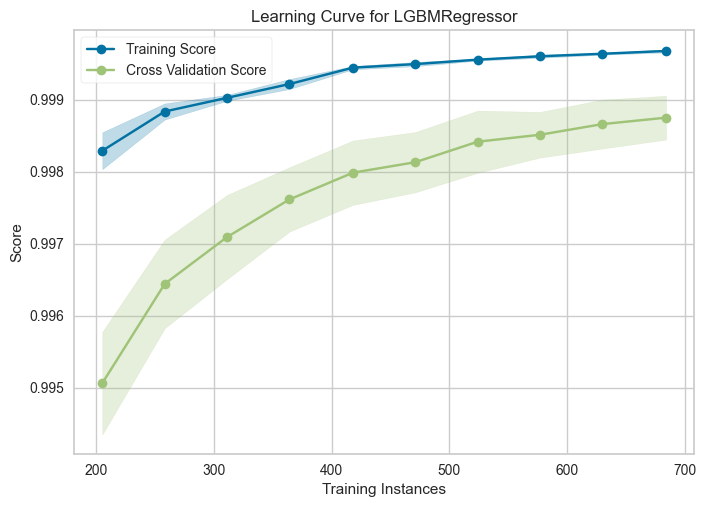

In [41]:
plot_model(best_model, plot='learning')

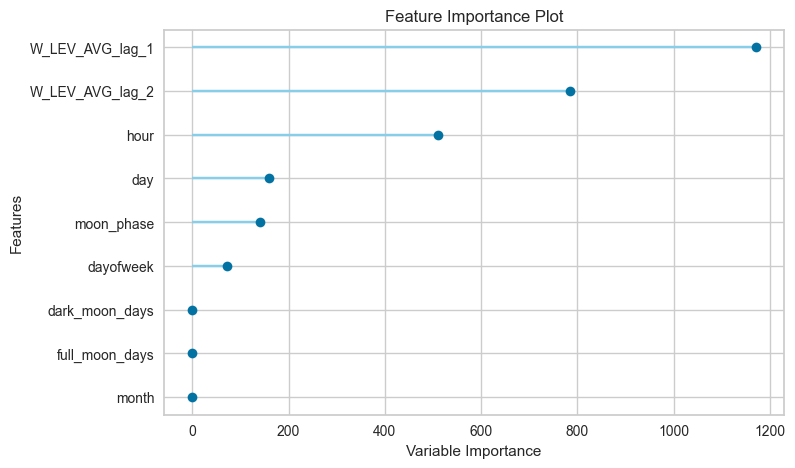

In [42]:
plot_model(best_model, plot='feature')

เทสกับข้อมูลอื่นในหลัก 10 นาที 1 ชั่วโมง และ 1 วันตามลำดับ

In [43]:
import pandas as pd
import numpy as np
from pycaret.regression import *
# W_LEV_AVG	= ค่าระดับน้ำทะเล หน่วยเมตร
# Load your dataset
df_test = pd.read_csv("data_preprocess/raw_data/dmr_tidal-level-chompon-tidegauge-2016_2023.csv")
# ลบช่องว่างเกินออก (กันกรณีมี space แปลก ๆ)
df_test["DATE"] = df_test["DATE"].str.strip()

# เติมเลข 0 ให้ชั่วโมงหลักเดียว และเติม ":00" ถ้าขาดวินาที
df_test["DATE"] = df_test["DATE"].str.replace(r"(\d{1,2}/\d{1,2}/\d{4}) (\d{1}):(\d{2})$", r"\1 0\2:\3:00", regex=True)
df_test["DATE"] = df_test["DATE"].str.replace(r"(\d{1,2}/\d{1,2}/\d{4}) (\d{2}:\d{2})$", r"\1 \2:00", regex=True)

# แปลงเป็น datetime โดยกำหนด dayfirst=True
df_test["DATE"] = pd.to_datetime(df_test["DATE"], format="%d/%m/%Y %H:%M:%S", dayfirst=True)
df_test.set_index('DATE', inplace=True)
df_test['dayofweek'] = df_test.index.dayofweek
df_test['month'] = df_test.index.month
df_test['day'] = df_test.index.day
df_test['hour'] = df_test.index.hour
df_test = df_test.drop(columns=["TW_ID", "TW_NAME", "UTM_E", 'UTM_N'], axis=1)
df_test

,W_LEV_AVG,dayofweek,month,day,hour
DATE,,,,,
2016-07-22 07:00:00,-0.7662,4,7,22,7
2016-07-22 07:10:00,-0.7625,4,7,22,7
2016-07-22 07:20:00,-0.7778,4,7,22,7
2016-07-22 07:30:00,-0.8250,4,7,22,7
2016-07-22 07:40:00,-0.8593,4,7,22,7
...,...,...,...,...,...
2023-12-31 23:10:00,-0.3997,6,12,31,23
2023-12-31 23:20:00,-0.3979,6,12,31,23
2023-12-31 23:30:00,-0.3970,6,12,31,23


In [44]:
# ฟังก์ชันหาข้างขึ้นข้างแรม
def get_moon_phase(dt):
    moon_phase = ephem.Moon(dt).phase  # คำนวณเฟสของดวงจันทร์
    return round(moon_phase)  # ปัดค่า phase ให้เป็นจำนวนเต็ม (0-29)

# คำนวณข้างขึ้นข้างแรม และเพิ่มเป็นคอลัมน์ใหม่
df_test["moon_phase"] = df_test.index.to_series().apply(get_moon_phase)

# เพิ่มคอลัมน์ full_moon_days (ขึ้น 15 ค่ำ) และ dark_moon_days (แรม 15 ค่ำ)
df_test["full_moon_days"] = (df_test["moon_phase"] == 15).astype(int) #(ขึ้น 15 ค่ำ)
df_test["dark_moon_days"] = (df_test["moon_phase"] == 29).astype(int) #(แรม 15 ค่ำ)

In [169]:
# Create lag features for the past 14 days
for lag in range(1, 19):  # Lags from 1 to 14 days
    df_test[f'W_LEV_AVG_lag_{lag}'] = df_test['W_LEV_AVG'].shift(lag)

# Drop NaN values caused by shifting
df_test.dropna(inplace=True)

In [170]:
test_prediction_m = exp.predict_model(best_model, data=df_test)
test_prediction_m

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,0.0167,0.0005,0.0217,0.9980,0.0152,0.2272


,dayofweek,month,day,hour,moon_phase,full_moon_days,dark_moon_days,W_LEV_AVG_lag_1,W_LEV_AVG_lag_2,W_LEV_AVG_lag_3,...,W_LEV_AVG_lag_11,W_LEV_AVG_lag_12,W_LEV_AVG_lag_13,W_LEV_AVG_lag_14,W_LEV_AVG_lag_15,W_LEV_AVG_lag_16,W_LEV_AVG_lag_17,W_LEV_AVG_lag_18,W_LEV_AVG,prediction_label
DATE,,,,,,,,,,,,,,,,,,,,,
2016-07-22 10:00:00,4,7,22,10,93,0,0,-0.9173,-0.9125,-0.8918,...,-0.8674,-0.8717,-0.8612,-0.8593,-0.8250,-0.7778,-0.7625,-0.7662,-0.8955,-0.899250
2016-07-22 10:10:00,4,7,22,10,93,0,0,-0.8955,-0.9173,-0.9125,...,-0.8855,-0.8674,-0.8717,-0.8612,-0.8593,-0.8250,-0.7778,-0.7625,-0.8758,-0.863819
2016-07-22 10:20:00,4,7,22,10,93,0,0,-0.8758,-0.8955,-0.9173,...,-0.8969,-0.8855,-0.8674,-0.8717,-0.8612,-0.8593,-0.8250,-0.7778,-0.8768,-0.838749
2016-07-22 10:30:00,4,7,22,10,93,0,0,-0.8768,-0.8758,-0.8955,...,-0.8944,-0.8969,-0.8855,-0.8674,-0.8717,-0.8612,-0.8593,-0.8250,-0.8683,-0.850867
2016-07-22 10:40:00,4,7,22,10,93,0,0,-0.8683,-0.8768,-0.8758,...,-0.8905,-0.8944,-0.8969,-0.8855,-0.8674,-0.8717,-0.8612,-0.8593,-0.8604,-0.843901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 23:10:00,6,12,31,23,78,0,0,-0.3997,-0.3846,-0.3797,...,-0.2651,-0.2469,-0.2201,-0.1949,-0.1731,-0.1539,-0.1355,-0.1111,-0.3997,-0.408408
2023-12-31 23:20:00,6,12,31,23,78,0,0,-0.3997,-0.3997,-0.3846,...,-0.2803,-0.2651,-0.2469,-0.2201,-0.1949,-0.1731,-0.1539,-0.1355,-0.3979,-0.402155
2023-12-31 23:30:00,6,12,31,23,78,0,0,-0.3979,-0.3997,-0.3997,...,-0.3030,-0.2803,-0.2651,-0.2469,-0.2201,-0.1949,-0.1731,-0.1539,-0.3970,-0.394239


In [171]:
df_test_h = df_test.resample("h").mean()
df_test_h.dropna(inplace=True)

# Create lag features for the past 14 days
for lag in range(1, 19):  # Lags from 1 to 14 days
    df_test_h[f'W_LEV_AVG_lag_{lag}'] = df_test_h['W_LEV_AVG'].shift(lag)
df_test_h.dropna(inplace=True)

test_prediction_h = exp.predict_model(best_model, data=df_test_h)
test_prediction_h

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,0.0727,0.0077,0.0878,0.9668,0.0624,1.6828


,dayofweek,month,day,hour,moon_phase,full_moon_days,dark_moon_days,W_LEV_AVG_lag_1,W_LEV_AVG_lag_2,W_LEV_AVG_lag_3,...,W_LEV_AVG_lag_11,W_LEV_AVG_lag_12,W_LEV_AVG_lag_13,W_LEV_AVG_lag_14,W_LEV_AVG_lag_15,W_LEV_AVG_lag_16,W_LEV_AVG_lag_17,W_LEV_AVG_lag_18,W_LEV_AVG,prediction_label
DATE,,,,,,,,,,,,,,,,,,,,,
2016-07-23 04:00:00,5.0,7.0,23.0,4.0,88.000000,0.0,0.0,0.307333,0.509617,0.637950,...,-0.425967,-0.506700,-0.571750,-0.638933,-0.717783,-0.792517,-0.823017,-0.871017,0.021067,0.189305
2016-07-23 05:00:00,5.0,7.0,23.0,5.0,88.000000,0.0,0.0,0.021067,0.307333,0.509617,...,-0.328733,-0.425967,-0.506700,-0.571750,-0.638933,-0.717783,-0.792517,-0.823017,-0.226000,-0.125197
2016-07-23 06:00:00,5.0,7.0,23.0,6.0,87.166664,0.0,0.0,-0.226000,0.021067,0.307333,...,-0.196950,-0.328733,-0.425967,-0.506700,-0.571750,-0.638933,-0.717783,-0.792517,-0.454333,-0.347208
2016-07-23 07:00:00,5.0,7.0,23.0,7.0,87.000000,0.0,0.0,-0.454333,-0.226000,0.021067,...,-0.016017,-0.196950,-0.328733,-0.425967,-0.506700,-0.571750,-0.638933,-0.717783,-0.614567,-0.526397
2016-07-23 08:00:00,5.0,7.0,23.0,8.0,87.000000,0.0,0.0,-0.614567,-0.454333,-0.226000,...,0.214950,-0.016017,-0.196950,-0.328733,-0.425967,-0.506700,-0.571750,-0.638933,-0.744100,-0.628655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,6.0,12.0,31.0,19.0,79.500000,0.0,0.0,0.256650,0.498333,0.759050,...,0.408083,0.209600,0.064233,-0.052000,-0.140717,-0.209483,-0.271000,-0.344250,0.036850,0.159561
2023-12-31 20:00:00,6.0,12.0,31.0,20.0,79.000000,0.0,0.0,0.036850,0.256650,0.498333,...,0.642400,0.408083,0.209600,0.064233,-0.052000,-0.140717,-0.209483,-0.271000,-0.141900,-0.023375
2023-12-31 21:00:00,6.0,12.0,31.0,21.0,79.000000,0.0,0.0,-0.141900,0.036850,0.256650,...,0.889250,0.642400,0.408083,0.209600,0.064233,-0.052000,-0.140717,-0.209483,-0.272483,-0.166520


In [172]:
df_test_d = df_test.resample("D").mean()
df_test_d.dropna(inplace=True)
# Create lag features for the past 14 days
for lag in range(1, 19):  # Lags from 1 to 14 days
    df_test_d[f'W_LEV_AVG_lag_{lag}'] = df_test_d['W_LEV_AVG'].shift(lag)
df_test_d.dropna(inplace=True)
test_prediction_d = exp.predict_model(best_model, data=df_test_d)
test_prediction_d

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,0.0944,0.0170,0.1306,0.7046,0.0927,2.0407


,dayofweek,month,day,hour,moon_phase,full_moon_days,dark_moon_days,W_LEV_AVG_lag_1,W_LEV_AVG_lag_2,W_LEV_AVG_lag_3,...,W_LEV_AVG_lag_11,W_LEV_AVG_lag_12,W_LEV_AVG_lag_13,W_LEV_AVG_lag_14,W_LEV_AVG_lag_15,W_LEV_AVG_lag_16,W_LEV_AVG_lag_17,W_LEV_AVG_lag_18,W_LEV_AVG,prediction_label
DATE,,,,,,,,,,,,,,,,,,,,,
2016-08-09,1.0,8.0,9.0,11.5,38.215279,0.0,0.0,-0.435174,-0.461972,-0.357922,...,-0.343085,-0.288399,-0.335149,-0.416648,-0.262940,-0.347915,-0.269145,-0.333580,-0.404411,-0.434636
2016-08-10,2.0,8.0,10.0,11.5,47.583332,0.0,0.0,-0.404411,-0.435174,-0.461972,...,-0.347185,-0.343085,-0.288399,-0.335149,-0.416648,-0.262940,-0.347915,-0.269145,-0.501238,-0.364642
2016-08-11,3.0,8.0,11.0,11.5,57.069443,0.0,0.0,-0.501238,-0.404411,-0.435174,...,-0.374085,-0.347185,-0.343085,-0.288399,-0.335149,-0.416648,-0.262940,-0.347915,-0.575842,-0.537758
2016-08-12,4.0,8.0,12.0,11.5,66.395836,0.0,0.0,-0.575842,-0.501238,-0.404411,...,-0.472896,-0.374085,-0.347185,-0.343085,-0.288399,-0.335149,-0.416648,-0.262940,-0.452125,-0.664886
2016-08-13,5.0,8.0,13.0,11.5,75.236115,0.0,0.0,-0.452125,-0.575842,-0.501238,...,-0.560056,-0.472896,-0.374085,-0.347185,-0.343085,-0.288399,-0.335149,-0.416648,-0.503794,-0.436640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,2.0,12.0,27.0,11.5,99.576385,0.0,0.0,0.650602,0.610687,0.538469,...,0.255712,0.264506,0.315138,0.280124,0.270866,0.200095,0.182337,0.212726,0.479415,0.692312
2023-12-28,3.0,12.0,28.0,11.5,97.548615,0.0,0.0,0.479415,0.650602,0.610687,...,0.405360,0.255712,0.264506,0.315138,0.280124,0.270866,0.200095,0.182337,0.411685,0.422715
2023-12-29,4.0,12.0,29.0,11.5,93.798615,0.0,0.0,0.411685,0.479415,0.650602,...,0.452292,0.405360,0.255712,0.264506,0.315138,0.280124,0.270866,0.200095,0.377428,0.312077


วัดความแม่นยำโดยใช้ MAE

In [174]:
#compare_data 30 index
from pycaret.regression import *
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Predict on the test set
test_predictions = exp.predict_model(best_model, data=compare_data)  # Last 7 known values

# Extract actual values and predicted values
y_true = compare_data["W_LEV_AVG"].values
y_pred = test_predictions["prediction_label"].values  # "prediction_label" contains predictions

# Calculate Regression Metrics
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Calculate Accuracy as (1 - (MAE / mean_actual)) * 100
mean_actual = np.mean(y_true)  # Mean of actual values
accuracy = max(0, min(100, (1 - (mae / mean_actual)) * 100))  # Accuracy in percentage

# Print Results
print(f"R² Score: {r2:.4f}")  # Closer to 1 is better
print(f"Mean Absolute Error (MAE): {mae:.4f}")  # Lower is better
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")  # Lower is better
print(f"Accuracy: {accuracy:.2f}%")  # Accuracy percentage


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,0.0127,0.0002,0.0153,0.9995,0.0102,0.1088


R² Score: 0.9995
Mean Absolute Error (MAE): 0.0127
Root Mean Squared Error (RMSE): 0.0153
Accuracy: 100.00%


In [175]:
# Train Data 
from pycaret.regression import *
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Predict on the test set
test_predictions = exp.predict_model(best_model, data=df)  # Last 7 known values

# Extract actual values and predicted values
y_true = df["W_LEV_AVG"].values
y_pred = test_predictions["prediction_label"].values  # "prediction_label" contains predictions

# Calculate Regression Metrics
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Calculate Accuracy as (1 - (MAE / mean_actual)) * 100
mean_actual = np.mean(y_true)  # Mean of actual values
accuracy = max(0, min(100, (1 - (mae / mean_actual)) * 100))  # Accuracy in percentage

# Print Results
print(f"R² Score: {r2:.4f}")  # Closer to 1 is better
print(f"Mean Absolute Error (MAE): {mae:.4f}")  # Lower is better
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")  # Lower is better
print(f"Accuracy: {accuracy:.2f}%")  # Accuracy percentage


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,0.0127,0.0007,0.0269,0.9988,0.0159,0.0903


R² Score: 0.9988
Mean Absolute Error (MAE): 0.0127
Root Mean Squared Error (RMSE): 0.0269
Accuracy: 100.00%


In [177]:
# Other file test data
from pycaret.regression import *
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Predict on the test set
test_predictions = exp.predict_model(best_model, data=df_test)  # Last 7 known values

# Extract actual values and predicted values
y_true = df_test["W_LEV_AVG"].values
y_pred = test_predictions["prediction_label"].values  # "prediction_label" contains predictions

# Calculate Regression Metrics
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Calculate Accuracy as (1 - (MAE / mean_actual)) * 100
mean_actual = np.mean(y_true)  # Mean of actual values
accuracy = max(0, min(100, (1 - (mae / mean_actual)) * 100))  # Accuracy in percentage

# Print Results
print(f"R² Score: {r2:.4f}")  # Closer to 1 is better
print(f"Mean Absolute Error (MAE): {mae:.4f}")  # Lower is better
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")  # Lower is better
print(f"Accuracy: {accuracy:.2f}%")  # Accuracy percentage


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,0.0167,0.0005,0.0217,0.9980,0.0152,0.2272


R² Score: 0.9980
Mean Absolute Error (MAE): 0.0167
Root Mean Squared Error (RMSE): 0.0217
Accuracy: 62.87%


วัดความแม่นยำโดยใช้ MAPE

In [178]:
#compare_data 30 index
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Predict on the test set
test_predictions = exp.predict_model(best_model, data=compare_data)

# Extract actual values and predicted values
y_true = compare_data["W_LEV_AVG"].values
y_pred = test_predictions["prediction_label"].values

# Filter out zeros from y_true to avoid division by zero in MAPE calculation
non_zero_indices = y_true != 0
y_true_non_zero = y_true[non_zero_indices]
y_pred_non_zero = y_pred[non_zero_indices]

# Calculate Regression Metrics
r2 = r2_score(y_true_non_zero, y_pred_non_zero)
mae = mean_absolute_error(y_true_non_zero, y_pred_non_zero)
rmse = np.sqrt(mean_squared_error(y_true_non_zero, y_pred_non_zero))

# Calculate MAPE and Accuracy for non-zero values
mape = np.mean(np.abs((y_true_non_zero - y_pred_non_zero) / y_true_non_zero)) * 100
accuracy = 100 - mape  # Convert to Accuracy %

# Print Results
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Accuracy: {accuracy:.2f}%")


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,0.0127,0.0002,0.0153,0.9995,0.0102,0.1088


R² Score: 0.9995
Mean Absolute Error (MAE): 0.0127
Root Mean Squared Error (RMSE): 0.0153
Mean Absolute Percentage Error (MAPE): 10.88%
Accuracy: 89.12%


In [179]:
# Train Data 
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Predict on the test set
test_predictions = exp.predict_model(best_model, data=df)

# Extract actual values and predicted values
y_true = df["W_LEV_AVG"].values
y_pred = test_predictions["prediction_label"].values

# Filter out zeros from y_true to avoid division by zero in MAPE calculation
non_zero_indices = y_true != 0
y_true_non_zero = y_true[non_zero_indices]
y_pred_non_zero = y_pred[non_zero_indices]

# Calculate Regression Metrics
r2 = r2_score(y_true_non_zero, y_pred_non_zero)
mae = mean_absolute_error(y_true_non_zero, y_pred_non_zero)
rmse = np.sqrt(mean_squared_error(y_true_non_zero, y_pred_non_zero))

# Calculate MAPE and Accuracy for non-zero values
mape = np.mean(np.abs((y_true_non_zero - y_pred_non_zero) / y_true_non_zero)) * 100
accuracy = 100 - mape  # Convert to Accuracy %

# Print Results
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Accuracy: {accuracy:.2f}%")


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,0.0127,0.0007,0.0269,0.9988,0.0159,0.0903


R² Score: 0.9989
Mean Absolute Error (MAE): 0.0126
Root Mean Squared Error (RMSE): 0.0259
Mean Absolute Percentage Error (MAPE): 9.03%
Accuracy: 90.97%


In [180]:
# Other file test data
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Predict on the test set
test_predictions = exp.predict_model(best_model, data=df_test)

# Extract actual values and predicted values
y_true = df_test["W_LEV_AVG"].values
y_pred = test_predictions["prediction_label"].values

# Filter out zeros from y_true to avoid division by zero in MAPE calculation
non_zero_indices = y_true != 0
y_true_non_zero = y_true[non_zero_indices]
y_pred_non_zero = y_pred[non_zero_indices]

# Calculate Regression Metrics
r2 = r2_score(y_true_non_zero, y_pred_non_zero)
mae = mean_absolute_error(y_true_non_zero, y_pred_non_zero)
rmse = np.sqrt(mean_squared_error(y_true_non_zero, y_pred_non_zero))

# Calculate MAPE and Accuracy for non-zero values
mape = np.mean(np.abs((y_true_non_zero - y_pred_non_zero) / y_true_non_zero)) * 100
accuracy = 100 - mape  # Convert to Accuracy %

# Print Results
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Accuracy: {accuracy:.2f}%")


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,0.0167,0.0005,0.0217,0.9980,0.0152,0.2272


R² Score: 0.9980
Mean Absolute Error (MAE): 0.0167
Root Mean Squared Error (RMSE): 0.0217
Mean Absolute Percentage Error (MAPE): 22.72%
Accuracy: 77.28%


ลองทำนายอนาคต

In [218]:
import pandas as pd
import ephem
# สร้าง DataFrame สำหรับอนาคต
future_dates = pd.date_range(df.index.max(), periods=3*24*60, freq="T")
future_df = pd.DataFrame(index=future_dates)  # ใช้เป็น index
future_df["DATE"] = future_df.index  # เพิ่มคอลัมน์ DATE
# คำนวณ moon phase
def get_moon_phase(dt):
    return round(ephem.Moon(dt).phase)
future_df["moon_phase"] = future_df["DATE"].apply(get_moon_phase)
# เพิ่ม full_moon_days (ขึ้น 15 ค่ำ) และ dark_moon_days (แรม 15 ค่ำ)
future_df["full_moon_days"] = (future_df["moon_phase"] == 15).astype(int)
future_df["dark_moon_days"] = (future_df["moon_phase"] == 29).astype(int)
# ดึงค่าเวลาออกมาเป็น feature
future_df["dayofweek"] = future_df["DATE"].dt.dayofweek
future_df["month"] = future_df["DATE"].dt.month
future_df["day"] = future_df["DATE"].dt.day
future_df["hour"] = future_df["DATE"].dt.hour
# สร้างค่าเริ่มต้นของ lag
lag_columns = [f"W_LEV_AVG_lag_{i}" for i in range(1, 19)]
for col in lag_columns:
    future_df[col] = None  # กำหนดค่าเริ่มต้นเป็น None หรือค่าเฉลี่ย
# ถ้าไม่มีข้อมูลจริงล่าสุด ใช้ค่าเฉลี่ยของ df
lag_mean_values = df[lag_columns].mean()
for col in lag_columns:
    future_df[col] = lag_mean_values[col]  # ใช้ค่าเฉลี่ยของ lag จากข้อมูลเก่า
# สร้างคอลัมน์ W_LEV_AVG เพื่อเก็บค่าที่ทำนาย
future_df['W_LEV_AVG'] = None
# กำหนด features ที่ใช้ในการทำนาย (ปรับตามที่ best_model ของคุณต้องการ)
model_features = ['moon_phase', 'full_moon_days', 'dark_moon_days', 'dayofweek', 
                  'month', 'day', 'hour'] + lag_columns
# ทำนาย step-by-step และอัปเดต lag feature 
for i in range(len(future_df)):
    # เตรียมข้อมูลสำหรับการทำนาย
    current_idx = future_df.index[i]
    
    # ดึงข้อมูล features สำหรับการทำนาย
    X_pred = future_df.loc[current_idx, model_features].values.reshape(1, -1)
    
    # ทำนายด้วย best_model
    predicted_value = best_model.predict(X_pred)[0]
    
    # บันทึกค่าที่ทำนายได้
    future_df.at[current_idx, 'W_LEV_AVG'] = predicted_value
    
    # อัปเดต lag features สำหรับข้อมูลถัดไป (ถ้าไม่ใช่ข้อมูลสุดท้าย)
    if i < len(future_df) - 1:
        next_idx = future_df.index[i+1]
        
        # อัปเดต lag_1 ด้วยค่าที่ทำนายได้ล่าสุด
        future_df.at[next_idx, 'W_LEV_AVG_lag_1'] = predicted_value
        
        # shift ค่า lag ที่เหลือ
        for j in range(18, 1, -1):
            future_df.at[next_idx, f"W_LEV_AVG_lag_{j}"] = future_df.at[current_idx, f"W_LEV_AVG_lag_{j-1}"]

# #แสดงผลลัพธ์รายนาที
# print("ข้อมูลรายนาที:")
# print(future_df[['DATE', 'W_LEV_AVG'] + lag_columns].head())

# สร้างข้อมูลรายวันโดยใช้ resample
daily_future_df = future_df.resample('H', on='DATE').mean()

# รีเซ็ต index เพื่อให้วันที่กลายเป็นคอลัมน์
daily_future_df = daily_future_df.reset_index()

# เพิ่มคอลัมน์วันที่เพื่อความชัดเจน
daily_future_df['date_only'] = daily_future_df['DATE'].dt.date

# เลือกเฉพาะคอลัมน์ที่สำคัญ
selected_columns = ['date_only', 'W_LEV_AVG', 'moon_phase']

# แสดงผลลัพธ์รายวัน
print("\nข้อมูลรายวัน:")
daily_future_df

# บันทึกเป็นไฟล์ถ้าต้องการ
# daily_future_df.to_csv('daily_water_level_forecast.csv', index=False)


ข้อมูลรายวัน:


,DATE,moon_phase,full_moon_days,dark_moon_days,dayofweek,month,day,hour,W_LEV_AVG_lag_1,W_LEV_AVG_lag_2,...,W_LEV_AVG_lag_11,W_LEV_AVG_lag_12,W_LEV_AVG_lag_13,W_LEV_AVG_lag_14,W_LEV_AVG_lag_15,W_LEV_AVG_lag_16,W_LEV_AVG_lag_17,W_LEV_AVG_lag_18,W_LEV_AVG,date_only
0,2023-12-28 23:00:00,96.000000,0.0,0.0,3.0,12.0,28.0,23.0,-0.295702,-0.278233,...,-0.214541,-0.214542,-0.214542,-0.214542,-0.214543,-0.214543,-0.214542,-0.214542,-0.315013,2023-12-28
1,2023-12-29 00:00:00,96.000000,0.0,0.0,4.0,12.0,29.0,0.0,-0.627115,-0.629068,...,-0.624227,-0.620932,-0.617171,-0.612958,-0.608322,-0.603299,-0.597919,-0.592195,-0.624745,2023-12-29
2,2023-12-29 01:00:00,96.000000,0.0,0.0,4.0,12.0,29.0,1.0,-0.597580,-0.593121,...,-0.544324,-0.538596,-0.533036,-0.527691,-0.522589,-0.517745,-0.513158,-0.508827,-0.601797,2023-12-29
3,2023-12-29 02:00:00,95.700000,0.0,0.0,4.0,12.0,29.0,2.0,-0.520130,-0.516004,...,-0.492262,-0.491646,-0.491523,-0.491879,-0.492688,-0.493918,-0.495537,-0.497522,-0.52451,2023-12-29
4,2023-12-29 03:00:00,95.000000,0.0,0.0,4.0,12.0,29.0,3.0,-0.498227,-0.499667,...,-0.526862,-0.531303,-0.535925,-0.540673,-0.545494,-0.550338,-0.555171,-0.559965,-0.497158,2023-12-29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,2023-12-31 19:00:00,79.416667,0.0,0.0,6.0,12.0,31.0,19.0,-0.540265,-0.540420,...,-0.541425,-0.541483,-0.541529,-0.541562,-0.541583,-0.541591,-0.541586,-0.541569,-0.540104,2023-12-31
69,2023-12-31 20:00:00,79.000000,0.0,0.0,6.0,12.0,31.0,20.0,-0.539332,-0.539332,...,-0.538885,-0.538796,-0.538700,-0.538601,-0.538497,-0.538390,-0.538280,-0.538170,-0.53932,2023-12-31
70,2023-12-31 21:00:00,79.000000,0.0,0.0,6.0,12.0,31.0,21.0,-0.536299,-0.536205,...,-0.535423,-0.535358,-0.535299,-0.535249,-0.535206,-0.535173,-0.535148,-0.535133,-0.536391,2023-12-31
71,2023-12-31 22:00:00,78.550000,0.0,0.0,6.0,12.0,31.0,22.0,-0.533249,-0.533229,...,-0.533463,-0.533535,-0.533615,-0.533704,-0.533801,-0.533905,-0.534016,-0.534134,-0.533277,2023-12-31
